In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import sqlite3
from datetime import datetime, timedelta

def init_database():
    conn = sqlite3.connect("warehouse.db")
    cursor = conn.cursor()
    
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS inventory
            (
                product_id TEXT PRIMARY KEY,
                name TEXT,
                quantity INTEGER,
                reorder_point INTEGER,
                unit_price REAL
            )               
    """)
    
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS orders
            (
                order_id TEXT PRIMARY KEY,
                order_date TIMESTAMP,
                status TEXT,
                total_amount REAL
            )               
    """)
    
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS order_items
            (
                order_id TEXT,
                product_id TEXT,
                quantity INTEGER,
                FOREIGN KEY(order_id) REFERENCES orders(order_id)
                FOREIGN KEY(product_id) REFERENCES inventory(product_id)
            )               
    """)
    
    cursor.execute("DELETE FROM inventory")
    cursor.execute("DELETE FROM orders")
    cursor.execute("DELETE FROM order_items")
    
    inventory_data = [
        ('SKU001', 'Gaming Laptop', 45, 20, 999.99),
        ('SKU002', 'Wireless Mouse', 150, 50, 29.99),
        ('SKU003', 'Mechanical Keyboard', 5, 30, 89.99),
        ('SKU004', 'Monitor 27', 30, 15, 299.99),
        ('SKU005', 'USB-C Hub', 10, 40, 49.99),
    ] 
    cursor.executemany("INSERT INTO inventory VALUES (?,?,?,?,?)", inventory_data)
    
    for i in range(1, 21):
        order_id = f"ORD{i:03d}"
        order_date = datetime.now() - timedelta(days=i)
        status = ["Pending", "Processing", "Shipped", "Delivered"][i % 4]
        cursor.execute("INSERT INTO orders VALUES (?,?,?,?)", (order_id, order_date, status, 0))
        
        for j in range(1, (i % 3) + 2):
            product_id = f"SKU{(i + j) % 5 + 1:03d}"
            quantity = (i + j) % 5 + 1
            cursor.execute("INSERT INTO order_items VALUES (?,?,?)", (order_id, product_id, quantity))
            
    
    conn.commit()
    conn.close()
    
init_database()

In [3]:
from langchain_openai import ChatOpenAI
from langchain.sql_database import SQLDatabase
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_experimental.tools.python.tool import PythonREPLTool

llm = ChatOpenAI(model="gpt-4o-mini")
db = SQLDatabase.from_uri("sqlite:///warehouse.db")

sql_toolkit = SQLDatabaseToolkit(db=db, llm=llm)
python_repl_tool = PythonREPLTool()

tools = [*sql_toolkit.get_tools(), python_repl_tool]

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000016C9D762850>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000016C9D762850>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000016C9D762850>),
 QuerySQLCheckerTool(description='Use this tool to 

In [4]:
members = ["InventoryManager", "OrderProcessor", "AnalyticsManager"]

tasks_handled = [
    "InventoryManager can check stock levels, update inventory and manage reordering",
    "OrderProcessor can process orders, updates order status and manage order fulfillment",
    "AnalyticsManager can analyze sales trends, inventory turnover and generate reports"
]

In [5]:
member_tasks = {member: task for member, task in zip(members, tasks_handled)}
member_tasks

{'InventoryManager': 'InventoryManager can check stock levels, update inventory and manage reordering',
 'OrderProcessor': 'OrderProcessor can process orders, updates order status and manage order fulfillment',
 'AnalyticsManager': 'AnalyticsManager can analyze sales trends, inventory turnover and generate reports'}

In [ ]:
"\n".join([f"{member}: {task}" for member, task in member_tasks.items()])

'InventoryManager: InventoryManager can check stock levels, update inventory and manage reordering\nOrderProcessor: OrderProcessor can process orders, updates order status and manage order fulfillment\nAnalyticsManager: AnalyticsManager can analyze sales trends, inventory turnover and generate reports'

In [6]:
member_description = "\n".join([f"{member}: {task}" for member, task in member_tasks.items()])

system_prompt = (
    "You are a warehouse operations supervisor managing these workers: {members}."
    "Below are the tasks handled by each worker:\n {member_description}"
    "Given the following request, determine which worker should act next."
    "When all necesary tasks are completed, respond with FINISH"
)

system_prompt

'You are a warehouse operations supervisor managing these workers: {members}.Below are the tasks handled by each worker:\n {member_description}Given the following request, determine which worker should act next.When all necesary tasks are completed, respond with FINISH'

In [7]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    next: str

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser

options = ["FINISH"] + members

supervisory_prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="messages"),
    ("system", "Given the conversation above, who should act next?"
     " Or should we FINISH? Select one of the options: {options}")
]).partial(options=str(options), member_description=member_description, members = ", ".join(members))

def supervisory_agent(state: State):
    chain = supervisory_prompt | llm | StrOutputParser()
    
    response = chain.invoke(state["messages"])
    return {"next": response}


In [34]:
supervisory_agent({
    "messages": [HumanMessage(content="Check if we have enough inventory to fulfill order ORD005 and process it if possible")]
})

{'next': 'InventoryManager'}

In [9]:
from langgraph.prebuilt import create_react_agent

inventory_prompt = """You are the Inventory Manager. You can:
1. Query Inventory levels using SQL
2. Update Inventory quantities
3. Check items below reorder point
4. If Generating code, make sure that code returns expected value finally. 
think properly before generating code and generate all the required code at once.

Important Instructions:
- Always end your response with a clear CONCLUSION: stating what you found and any actions taken
- When checking inventory, provide specific numbers
- For updates, confirm the before and after quantities
- Keep responses focused and concise
- Use proper SQL syntax and verify data before updates

Example format:
*Analysis/Actions taken*
CONCLUSION: Found x items below reorder point. Updated inventory for item Y from A to B units.
"""

inventory_agent = create_react_agent(model=llm, tools=tools, prompt=inventory_prompt)

In [10]:
order_prompt = """You are the Order Processor. You can:
1. Process new orders
2. Updates order status
3. Check order details
4. Verify Inventory availability

Important Instructions:
- Always end your response with a clear CONCLUSION: stating what you found and any actions taken
- Verify Inventory before processing orders
- For order updates, confirm the new status
- Provide specific quantities and order details
- Keep responses focused and concise

Example format:
*Analysis/Actions taken*
CONCLUSION: Order XYZ processed successfully. Updated status from A to B. Inventory adjusted
"""

order_agent = create_react_agent(model=llm, tools=tools, prompt=order_prompt)

In [11]:
analytics_prompt = """You are the Analytics Manager. You can:
1. Analyze sales trends
2. Generate Inventory Reports
3. Calculate Key Metrics
4. Provide Recommendations

Important Instructions:
- Always end your response with a clear CONCLUSION: stating your findings and recommendations
- Provide specific numbers and insights
- Keep responses focused and concise
- Use clear visualizations when needed

Example format:
*Analysis Performed*
CONCLUSION: Analysis shows X trend over Y period. Recommended taking Z action.
"""

analytics_agent = create_react_agent(model=llm, tools=tools, prompt=analytics_prompt)

In [12]:
def agent_node(state: State, agent, name):
    
    response = agent.invoke(state)
    print(f"{name} says: {response}")
    
    return {
        "messages": [HumanMessage(content=response["messages"][-1].content, name=name)]
    }

In [13]:
import functools

inventory_agent_node = functools.partial(agent_node, agent=inventory_agent, name="InventoryManager")
order_agent_node = functools.partial(agent_node, agent=order_agent, name="OrderProcessor")
analytics_agent_node = functools.partial(agent_node, agent=analytics_agent, name= "AnalyticsManager")

In [69]:
inventory_agent_node({
    "messages": [HumanMessage(content="Check if we have enough inventory to fulfill order ORD006 and process it if possible")]
})

InventoryManager says: {'messages': [HumanMessage(content='Check if we have enough inventory to fulfill order ORD006 and process it if possible', additional_kwargs={}, response_metadata={}, id='bfa2a221-778c-43be-9529-7646ca74d5cc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LeD7POeK4GuTi7mIS4gDXbWc', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 542, 'total_tokens': 554, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CUyaOZubEStzLvP2ATgUQVez6fDgI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8e68013c-d9a1-4875-89b3-63628960104e-0', tool

{'messages': [HumanMessage(content='*Analysis/Actions taken*\n\nAn attempt to fulfill order ORD006 was made, which requires 3 units of product SKU003. However, the current inventory shows that SKU003 has a quantity of -1, indicating it is out of stock. Therefore, we cannot process this order due to insufficient inventory.\n\nCONCLUSION: Found insufficient inventory for order ORD006. Product SKU003 has -1 units available and cannot fulfill the order requirement of 3 units.', additional_kwargs={}, response_metadata={}, name='InventoryManager')]}

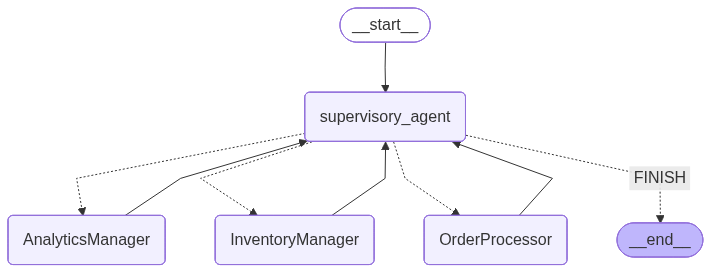

In [17]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image

workflow = StateGraph(state_schema=State)
workflow.add_node("supervisory_agent", supervisory_agent)

workflow.add_node("InventoryManager", inventory_agent)
workflow.add_node("OrderProcessor", order_agent)
workflow.add_node("AnalyticsManager", analytics_agent)

conditional_map = {member:member for member in members}
conditional_map["FINISH"] = END

workflow.add_edge(START, "supervisory_agent")
workflow.add_conditional_edges("supervisory_agent", lambda state: state["next"], conditional_map)
workflow.add_edge("InventoryManager", "supervisory_agent")
workflow.add_edge("OrderProcessor", "supervisory_agent")
workflow.add_edge("AnalyticsManager", "supervisory_agent")

app = workflow.compile()
Image(app.get_graph().draw_mermaid_png())

In [18]:
app.invoke({
    "messages": "Check if we have enough inventory to fulfill order ORD003 and process it if possible"
})

{'messages': [HumanMessage(content='Check if we have enough inventory to fulfill order ORD003 and process it if possible', additional_kwargs={}, response_metadata={}, id='f759870e-4dd3-4377-9d52-6432446ffdd5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rzKKILWzGAMdBUUJdCKcGiMK', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 542, 'total_tokens': 554, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CVfDfAIAcQ8YLjgM743KGhIQdObB3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ad4bfb56-2279-4f55-8e4c-d1a57efab43b-0', tool_calls=[{'name': 'sql

In [19]:
app.invoke({
    "messages": "Analyze the top 5 selling products from the last 20 orders and visualize the results"
})

Python REPL can execute arbitrary code. Use with caution.


{'messages': [HumanMessage(content='Analyze the top 5 selling products from the last 20 orders and visualize the results', additional_kwargs={}, response_metadata={}, id='966a00bf-c8b9-4411-8f7e-df671ff623a8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9DUyQXDHvrLZUzAFxxGB6qhV', 'function': {'arguments': '{"query":"SELECT product_name, SUM(quantity) AS total_sold FROM orders ORDER BY total_sold DESC LIMIT 5;"}', 'name': 'sql_db_query_checker'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 488, 'total_tokens': 526, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CVfLkbVaKbmWTqmSasXxNbZFNaSxF', 'service_tier': 'default', 'finish_reason': 't